In [701]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.patches as mpatches
from torch.utils.data import TensorDataset, DataLoader

# **Problem description**

Simple model $x = \theta + \epsilon \ \text{with}\ \epsilon\sim \mathcal{N}(0 ; \sigma^{2})\ ; \ \sigma^{2} = 0.01 \\$
Prior on theta
$$ p(\theta) = \mathcal{N}(\mu_0,\,\sigma_0^2)$$
Posterior
$$p(\theta \mid x) = \mathcal{N}(m,\,s^2)$$
$$m = \left(\frac{\frac{\mu_0}{\sigma_0^2} + \frac{x}{\sigma^2}}{\frac{1}{\sigma_0^2} + \frac{1}{\sigma^2}}\right)
\ \text{ and } \ s^{2} = \left(\frac{1}{\sigma_0^2} + \frac{1}{\sigma^2} \right)^{-1}$$


But suppose we only have $$\mathcal{D} = \{(\theta_i, x_i)\} \ \text{with} \ $$
$$\begin{aligned}
\theta_i &\sim p(\theta) \\
x_i &\sim p(x \mid \theta_i) \\
(\theta_i, x_i) &\sim p(\theta, x) = p(\theta) p(x \mid \theta)
\end{aligned}$$
We are looking for a function f, such that
$ \theta = f(x,z) = \alpha z + (\beta x + \gamma) $ with $z \sim \mathcal{N}(0 ; 1) $ and x the context. The parameters are estimated by minimising the forward Kullback-Leibler divergence, that is $$arg(min_{\phi} (L(\alpha,\beta,\gamma)) ) = arg\min_{\phi}\mathbb{E}_{x}\left[KL(p(\theta \mid x)\vert \vert q_{\phi}(\theta \mid x)) \right] \\
 \approx - \frac{1}{N} \sum_{i=1}^{N} \log(q_{\phi}(\theta_i \mid x_i)) \; (\theta_i, x_i) \sim p(\theta, x); \\
 \phi = (\alpha;\beta;\gamma)$$

In [702]:
sigma = 0.1 #sigma²=0.01
mu0 = 42
sigma0 = 2

sigma_T = torch.Tensor([sigma])
mu0_T = torch.Tensor([mu0])
sigma0_T = torch.Tensor([sigma0])

base_distribution = torch.distributions.Normal(torch.Tensor([0.0]), torch.Tensor([1.0]))

In [703]:
def generate_dataset(N:int):
    """Generate a tensor of x and thetas generated according to
    x = theta + epsilon; espilon ~N(0;sigma0)

    Args:
        N (int): Length of the dataset

    Returns:
        torch.Tensor : Tensor with x in the first columns and thetas in the 2nd one
    """
    res = torch.Tensor( N, 2) 
    thetas = torch.distributions.Normal(mu0_T, sigma0_T).sample((N, 1)) #Prior
    epsilons = torch.distributions.Normal(torch.Tensor([0]), sigma_T).sample((N, 1)) #Gaussian noise
    x = thetas + epsilons #Simulator
    res[:,0] = x.squeeze()
    res[:,1] = thetas.squeeze()
    return res

D = generate_dataset(1000)
print(D)
x, thetas = D[:,0], D[:,1]
D_test = generate_dataset(1000)
thetas_test, x_test = D_test[:,0], D_test[:,1]

tensor([[42.8084, 42.7796],
        [39.7005, 39.5759],
        [44.0156, 44.1088],
        ...,
        [41.7425, 41.7456],
        [38.1357, 37.9041],
        [38.0647, 38.1909]])


In [704]:
torch.manual_seed(42)

In [705]:
    class flow(nn.Module):
        
        def __init__(self,base, omega=None, beta=None, gamma=None):
            """Initialise the function, parametrised by exp(omega), beta and gamma
            f(x, z) = exp(omega)*z +  beta*x + gamma

            Args:
                base (torch.distributions): Base distribution, simple to sample from
                omega (float, optional): Defaults to None.
                beta (float, optional): Defaults to None.
                gamma (float, optional): Defaults to None.
            """
            super(flow, self).__init__()
            
            if omega is None:
                omega = torch.distributions.Uniform(-1.0,1.0).sample((1, ))
            self.omega = nn.Parameter(torch.Tensor([omega]), requires_grad=True)
            
            if beta is None:
                beta = torch.distributions.Uniform(-1.0,1.0).sample((1, ))
            self.beta = nn.Parameter(torch.Tensor([beta]), requires_grad= True)
            
            if gamma is None:
                gamma = torch.distributions.Uniform(-1.0,1.0).sample((1, ))
            self.gamma = nn.Parameter(torch.Tensor([gamma]), requires_grad= True)
            
            self.base = base

            
        def forward(self, x):
            """Compute the forward f(x, z) = exp(omega)*z + beta*x+gamma = theta and returns theta

            Args:
                x (torch.Tensor): Context

            Returns:
                torch.Tensor: f(x, z)
            """
            z = self.base.sample(x.size())
            theta = torch.exp(self.omega)*z + self.beta * x + self.gamma
            return theta
        
        def loss(self, thetas, X):
            """Computes the loss corresponding to the forward KL-divergence
            q(theta | x) = density of N(beta*x+gamma; alpha²)
            loss = - 1/N *sigma(log(q(theta_i | x_i)))
            Args:
                thetas (torch.Tensor)
                X (torch.Tensor)

            Returns:
                float: Corresponding loss
            """
            
            res = 0          
            est_mean = self.beta*X + self.gamma
            est_std = torch.exp(self.omega)
            logprob = torch.distributions.Normal(torch.Tensor(est_mean), torch.Tensor(est_std)).log_prob(thetas)
            res += logprob.sum()
            return -res.mean()
            
        def sample(self, x, size):
            """Sample theta given x according to theta=f(x, z)

            Args:
                x (torch.Tensor): Context
                size (tuple)

            Returns:
                torch.Tensor
            """
            with torch.no_grad():    
                thetas_hat = torch.zeros(size)
                for i in range(size[0]):
                    thetas_hat[i] = self.forward(x)
            return thetas_hat

f = flow(base_distribution,6.0,1.0,1.0)

In [706]:
dataset = TensorDataset(thetas, x)
batch_size = 32
loader = DataLoader(dataset,batch_size,shuffle=True)

In [707]:
n_iter = 10000
learning_rate = 1e-3
optimizer = torch.optim.Adam(f.parameters(), learning_rate)
losses_train = []
epsilon = 1e-5
estimated_alpha = []
estimated_beta = []
estimated_gamma = []
with torch.no_grad():
    previous_loss = f.loss(thetas_test,x_test).mean().detach().item()
counter=1
patience = 2
for i in range(n_iter):
    loss_batch = []
    for batch_idx, batch in enumerate(loader):
        thetas_i,x_i = batch
        loss_train = f.loss(thetas_i,x_i)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        loss_batch.append(loss_train.detach().item())
    losses_train.append(np.mean(loss_batch))    
    estimated_alpha.append(torch.exp(f.omega).detach().item())
    estimated_beta.append(f.beta.detach().item())
    estimated_gamma.append(f.gamma.detach().item())
        
        
    if i%20==0:
        with torch.no_grad():
            loss_test = f.loss(thetas_test,x_test)
            if np.abs(loss_test - previous_loss) < epsilon:
                counter += 1
            if counter == patience:
                print(f"Early stop at iteration {i}")
                break
            previous_loss = loss_test
    if i%200==0:
        print(f"Iteration {i} and loss = {loss_train}")


Iteration 0 and loss = 55.10352325439453
Iteration 200 and loss = 4.46779727935791
Iteration 400 and loss = -4.034502983093262
Iteration 600 and loss = -6.963703155517578
Iteration 800 and loss = -6.716353893280029
Iteration 1000 and loss = -10.047252655029297
Iteration 1200 and loss = -6.521265983581543
Iteration 1400 and loss = -2.8561878204345703
Iteration 1600 and loss = -5.022214412689209
Iteration 1800 and loss = -5.525325775146484
Iteration 2000 and loss = -9.791964530944824
Iteration 2200 and loss = -3.4099020957946777
Iteration 2400 and loss = -6.960572242736816
Iteration 2600 and loss = -8.335745811462402
Iteration 2800 and loss = -7.096618175506592
Iteration 3000 and loss = -4.633716583251953
Iteration 3200 and loss = -5.703031063079834
Iteration 3400 and loss = -7.752516746520996
Iteration 3600 and loss = -7.328973770141602
Iteration 3800 and loss = -5.5375285148620605
Iteration 4000 and loss = -9.431158065795898
Iteration 4200 and loss = -9.481484413146973
Iteration 4400 a

In [708]:
C = (   mu0/(sigma0**2)  ) * ( 1/sigma0**2 + 1/sigma**2  )**(-1)
B = ( 1/sigma**2 ) * (1/sigma**2 + 1/sigma0**2 )**(-1)
A = ( 1/sigma0**2 + 1/sigma**2)**(-1/2)
alpha_inf = mu0**2 + (1 + (sigma0/sigma)**2 ) * (A**2)

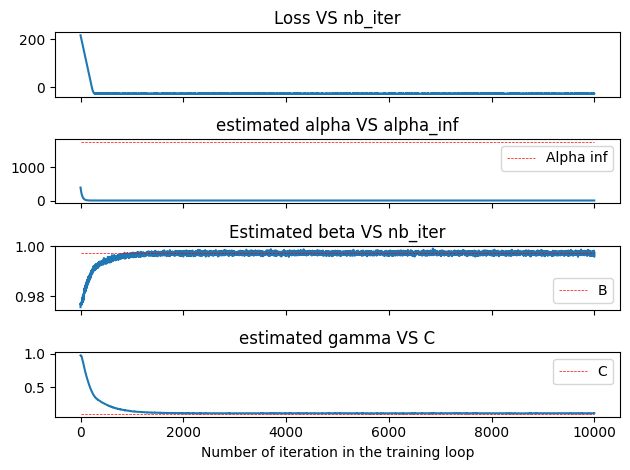

In [709]:
fig, axs = plt.subplots(4, sharex = True)
axs[0].plot(losses_train)
axs[0].set_title("Loss VS nb_iter")
axs[1].plot(estimated_alpha)
axs[1].hlines(y=alpha_inf,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="Alpha inf", linestyles='dashed')
axs[1].legend()
axs[1].set_title("estimated alpha VS alpha_inf")
axs[2].plot(estimated_beta)
axs[2].hlines(y=B,xmin=0, xmax=n_iter, linewidth=0.5, color='r', label="B", linestyles='dashed')
axs[2].legend()
axs[2].set_title("Estimated beta VS nb_iter")
axs[3].plot(estimated_gamma)
axs[3].hlines(y=C,xmin=0,xmax=n_iter,linewidth=0.5,color='r',label="C",linestyles='dashed')
axs[3].legend()
axs[3].set_title("estimated gamma VS C")
plt.xlabel("Number of iteration in the training loop")
fig.tight_layout()

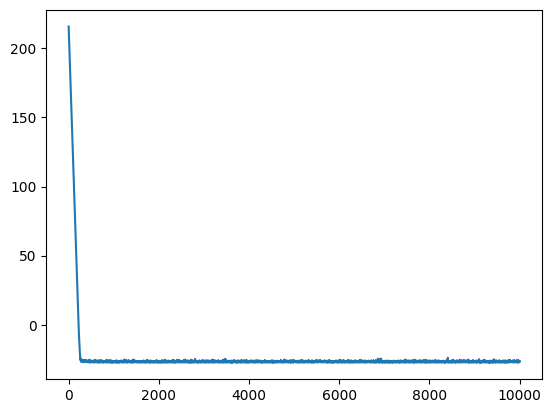

In [710]:
plt.plot(losses_train) #TODO Lisser la courbe en prenant la moyenne par batch?

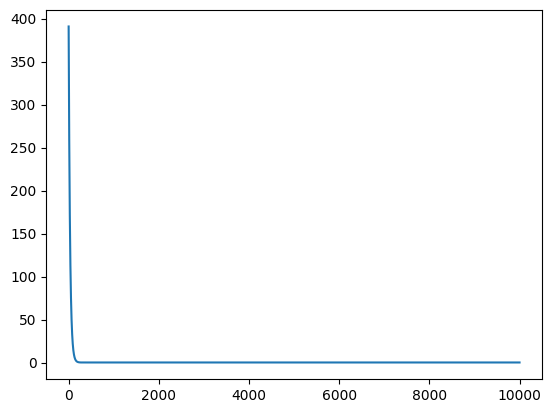

In [711]:
plt.plot(estimated_alpha)

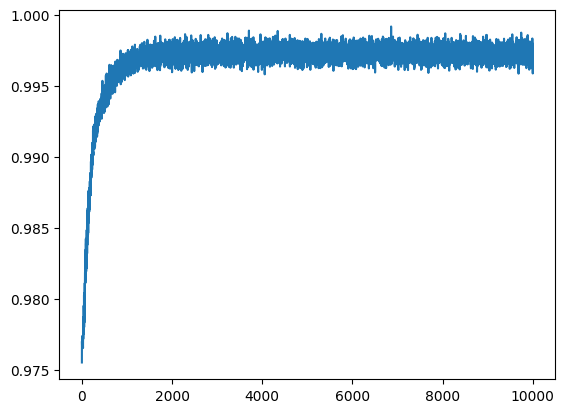

In [712]:
plt.plot(estimated_beta)

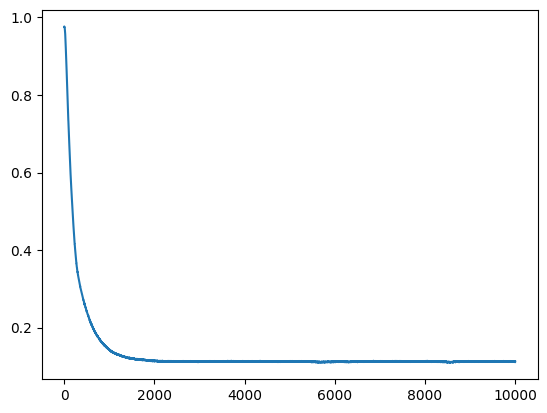

In [713]:
plt.plot(estimated_gamma)

In [714]:
print(f" C = {C} and gamma = {f.gamma.item()}")
print(f"B = {B} ansd beta = {f.beta.item()}")
print(f" alpha_inf = {alpha_inf} and alpha^2 estimated = {torch.exp(f.omega).item()**2}")

 C = 0.10473815461346635 and gamma = 0.11224614828824997
B = 0.9975062344139651 ansd beta = 0.9975115060806274
 alpha_inf = 1768.0 and alpha^2 estimated = 0.010680921904529461


In [715]:
def visualisation(f,N):
    fig, axs = plt.subplots(N)
    for n in range(N):
        x = generate_dataset(1)[:,0]
        m = (mu0/sigma0**2 + x/sigma**2) * (1/sigma0**2 + 1/sigma**2)**(-1)
        s2 = (1/sigma0**2 + 1/sigma**2)**(-1)
        s = np.sqrt(s2)
        true_post = torch.distributions.Normal(torch.Tensor([m]), torch.Tensor([s]))
        true_theta = true_post.sample((8000,1))
        theta_hat = f.sample(x,(8000,1))
        sns.kdeplot(true_theta.detach().numpy().flatten(), ax=axs[n],color='b')
        sns.kdeplot(theta_hat.detach().numpy().flatten(), ax=axs[n],color='g')
        axs[n].axvline(x.item(),color='r')
        axs[n].set_title(f"Estimated and true densities of theta |x, run {n}")
    blue_patch = mpatches.Patch(color='b',label="True theta distribution | x")
    green_patch = mpatches.Patch(color='g',label='Estimated distribution of theta | x')
    
    fig.legend(handles=[blue_patch,green_patch], loc='upper right', bbox_to_anchor=(1.40, 1))
    fig.tight_layout()

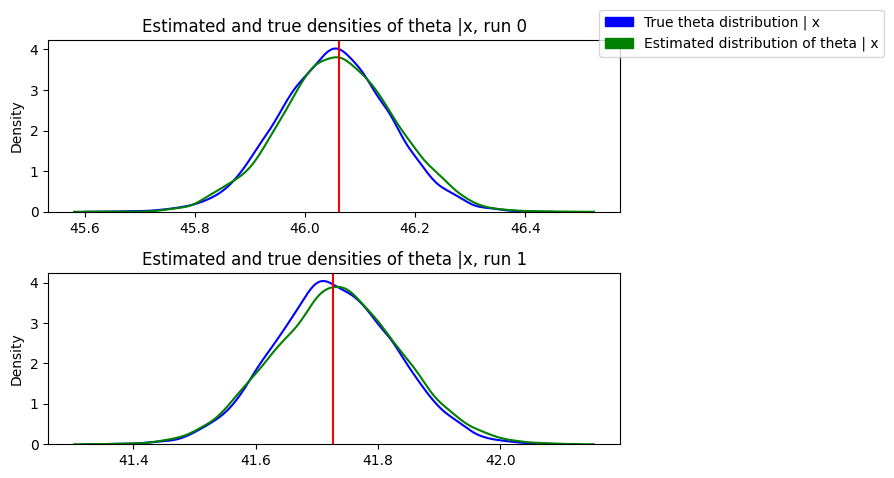

In [716]:
visualisation(f,2)